# ECED4406 Lab 4 - Power Analysis for Password Bypass

**SUMMARY:** *This tutorial will introduce you to breaking devices by determining when a device is performing certain operations. Our target device will be performing a simple password check, and we will demonstrate how to perform a basic power analysis.*

**LEARNING OUTCOMES:**

* How power can be used to determine timing information.
* Plotting multiple iterations while varying input data to find interesting locations.
* Using difference of waveforms to find interesting locations.


## ChipWhisperer Tutorial Links

This tutorial will use material from the ChipWhisperer project, see the https://github.com/newaetech/chipwhisperer-jupyter/tree/master/courses/sca101 folder. This tutorial follows tutorial 2.1B.

Note you can find the solution notebook as well there - if you get stuck on what code you should be running, see the notebook entitled "SOLN_Lab 2_1B - Power Analysis for Password Bypass.ipynb".

The code we are testing can be [seen here](https://github.com/newaetech/chipwhisperer/blob/develop/hardware/victims/firmware/basic-passwdcheck/basic-passwdcheck.c#L103). The specific part of the password check is:

```
        for(uint8_t i = 0; i < sizeof(correct_passwd); i++){
            if (correct_passwd[i] != passwd[i]){
                passbad = 1;
                break;
            }
        }
```

# Connect to ChipWhisperer

To start with, connect to the ChipWhisperer by plugging in the CW-Nano and running these cells:

In [ ]:
SCOPETYPE="CWNANO"
PLATFORM='CWNANO'
CRYPTO_TARGET='NONE'
VERSION='HARDWARE'

In [ ]:
import chipwhisperer as cw

try:
    if not scope.connectStatus:
        scope.con()
except NameError:
    scope = cw.scope()
    
SS_VER="SS_VER_1_1"
target_type = cw.targets.SimpleSerial

try:
    target = cw.target(scope, target_type)
except:
    print("INFO: Caught exception on reconnecting to target - attempting to reconnect to scope first.")
    print("INFO: This is a work-around when USB has died without Python knowing. Ignore errors above this line.")
    scope = cw.scope()
    target = cw.target(scope, target_type)

print("INFO: Found ChipWhisperer😍")    

In [ ]:
import time
time.sleep(0.05)
scope.default_setup()

def reset_target(scope):
    scope.io.nrst = 'low'
    time.sleep(0.05)
    scope.io.nrst = 'high_z'
    time.sleep(0.05)

In [ ]:
prog = cw.programmers.STM32FProgrammer

In [ ]:
cw.program_target(scope, prog, "cwnano-lab4-secret.hex".format(PLATFORM))

This should give you some output that looks like this:
```
Detected known STMF32: STM32F03xx4/03xx6
Extended erase (0x44), this can take ten seconds or more
Attempting to program 4499 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 4499 bytes
```

The red & green lights on the "target" section should be on too.

# Checking the Serial Output

The following cells will reset the device & then print the "startup" message. You could also connect to a serial console and see this, but it's handier for us to do it all inside of ChipWhisperer.

In [ ]:
target.flush()
reset_target(scope)
time.sleep(0.05)
print(target.read())

What you *should* see there is the following output:

```
** Safe-o-matic 3000 Booting...
Aligning bits........[DONE]
Checking Cesium RNG..[DONE]
Masquerading flash...[DONE]


WARNING: UNAUTHORIZED ACCESS WILL BE PUNISHED
Please enter password: 
```

We can write a password like this:

In [ ]:
target.write("hunter2\n")

In [ ]:
time.sleep(0.05)
target.read()

Looks like 'hunter2' isn't the right password! Let's use power analysis to recover it.

## Automatic Power Trace?

The following little function will send a password guess while recording a power trace. Let's keep this in our back pocket.
Run this cell to create the function.

In [ ]:
def cap_pass_trace(pass_guess):
    reset_target(scope)
    num_char = target.in_waiting()
    while num_char > 0:
        target.read(num_char, 10)
        time.sleep(0.01)
        num_char = target.in_waiting()

    scope.arm()
    target.write(pass_guess)
    ret = scope.capture()
    if ret:
        print('Timeout happened during acquisition')

    trace = scope.get_last_trace()
    return trace[0:500]

## Exploration

So what can we do with this? While first off - I'm going to cheat, and tell you that we have a 4-digit password that is all lowercase alpahet letters (e.g., 'a', 'b', 'c', 'd', .... , 'z'). 

If you need a reminder of how to do a plot - see the matplotlib section of the **Jupyter Introduction** notebook.

The following cell shows you how to capture one power trace with `a` sent as a password. From there:

1. Try adding the plotting code and see what it looks like.
2. Send different passwords to the device.
3. Plot the different waveforms.

Next we'll do this in a loop.

In [ ]:
%matplotlib notebook
import matplotlib.pylab as plt

#Example - capture a password with newline '\n' as serial protocol expects that
trace = cap_pass_trace("a\n")

#print(trace)

plt.plot(trace)

OK interesting -- what's next? Let's plot every possible password character we could send.

Our password implementation only recognizes characters in the list `abcdefghijklmnopqrstuvwxyz0123456789`, so we're going to limit it to those valid characters for now.

Write some code in the following block that implements the following algorithm:

    for CHARACTER in LIST_OF_VALID_CHARACTERS:
        trace = cap_pass_trace(CHARACTER + "\n")
        plot(trace)
        
The above isn't quite valid code - so massage it into place! You also may notice the traces are way too long - you might want to make a more narrow plot that only does the first say 500 samples of the power trace.

---
📝**Plotting Note**

If using `matplotlib` for plotting, you might need to add a `plt.figure()` at the start to make a new figure. Otherwise you might find your plot ends up in the figure above! If you don't see the plots, sometimes a `plt.show()` is needed at the end.

---

In the cell below there is the answer to the problem already encoded - you can take a look at that and copy the answer above it.

In [ ]:
guess_list = "abcdefghijklmnopqrstuvwxyz"

#plt.figure()

#for guess in guess_list:
#    trace = cap_pass_trace(guess + "\n")
#    plt.plot(trace[0:100]) 

The end result should be if you zoom in, you'll see there is a location where a single "outlier" trace doesn't follow the path of all the other traces. That is great news, since it means we learn something about the system from power analysis.

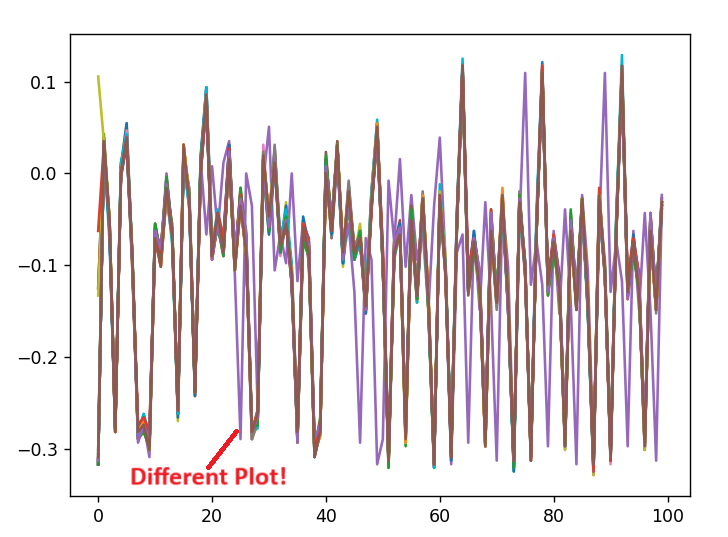

Using your loop - you can also try modifying the analysis to capture a correct "first" character, and then every other wrong second character. Do you see a difference you might be able to detect?

The pseudo-code would look something like this, assuming the first character was 'a' (but it's not, you'll have to discover that).

    for CHARACTER in LIST_OF_VALID_CHARACTERS:
        trace = cap_pass_trace("a" + CHARACTER + "\n")
        plot(trace)

Give that a shot in your earlier code-block, and then let's try and automate this attack to understand the data a little better.

## Automating an Attack against One Character

To start with - we're going to automate an attack against a **single** character of the password. Since we don't know the password (let's assume), we'll use a strategy of comparing all possible inputs together.

An easy way to do this might be to use something that we know can't be part of the valid password. As long as it's processed the same way, this will work just fine. So for now, let's use a password as `0x00` (i.e., a null byte). We can compare the null byte to processing something else:

In [ ]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.figure()
ref_trace = cap_pass_trace("\x00\n")[0:500]
plt.plot(ref_trace)
other_trace = cap_pass_trace("c\n")[0:500]
plt.plot(other_trace)

This will plot a trace with an input of "\x00" - a null password! This is an invalid character, and seems to be processed as any other invalid password.

Let's make this a little more obvious, and plot the difference between a known reference & every other capture. You need to write some code that does something like this:

    ref_trace = cap_pass_trace( "\x00\n")

    for CHARACTER in LIST_OF_VALID_CHARACTERS:
        trace = cap_pass_trace(CHARACTER + "\n")
        plot(trace - ref_trace)

Again, you may need to modify this a little bit such as adding code to make a new `figure()`. Also notice in the above example how I reduced the number of samples.


In [ ]:
# ###################
# Add your code here
# ###################
raise NotImplementedError("Add your code here, and delete this.")

OK great - hopefully you now see one major "difference". It should look something like this:
    
<img src="img/spa_password_diffexample.png" alt="SPA with Difference" width="450"/>
    

What do do now? Let's make this thing automatically detect such a large difference. Some handy stuff to try out is the `np.sum()` and `np.abs()` function.

The first one will get absolute values:

```python
import numpy as np
np.abs([-1, -3, 1, -5, 6])

    Out[]: array([1, 3, 1, 5, 6])
```

The second one will add up all the numbers.

```python
import numpy as np    
np.sum([-1, -3, 1, -5, 6])

    Out[]: -2
```

Using just `np.sum()` means positive and negative differences will cancel each other out - so it's better to do something like `np.sum(np.abs(DIFF))` to get a good number indicating how "close" the match was.


In [ ]:
import numpy as np
np.abs([-1, -3, 1, -5, 6])

In [ ]:
import numpy as np
np.sum([-1, -3, 1, -5, 6])

In [ ]:
np.sum(np.abs(<COPY DATA HERE>))

Taking your above loop, modify it to print an indicator of how closely this matches your trace. Something like the following should work:

    ref_trace = cap_pass_trace( "\x00\n")

    for CHARACTER in LIST_OF_VALID_CHARACTERS:
        trace = cap_pass_trace(CHARACTER + "\n")
        diff = SUM(ABS(trace - ref_trace))

        print("{:1} diff = {:2}".format(CHARACTER, diff))

In [ ]:
# ###################
# Add your code here
# ###################
raise NotImplementedError("Add your code here, and delete this.")

Now the easy part - modify your above code to automatically print the correct password character. This should be done with a comparison of the `diff` variable - based on the printed characters, you should see one that is 'higher' than the others. Set a threshold somewhere reasonable (say I might use `25.0` based on one run).

## Running a Full Attack

Finally - let's finish this off. Rather than attacking a single character, we need to attack each character in sequence.

If you go back to the plotting of differences, you can try using the correct first character & wrong second character. The basic idea is exactly the same as before, but now we loop through 4 times, and just build up the password based on brute-forcing each character.

Take a look at the following for the basic pseudo-code:

    guessed_pw = "" #Store guessed password so far
    
    do a loop 4 times (max password size):
        
        ref_trace = capture power trace(guessed_pw + "\x00\n")
        
        for CHARACTER in LIST_OF_VALID_CHARACTERS:
            trace = capture power trace (guessed_pw + CHARACTER + newline)
            diff = SUM(ABS(trace - ref_trace))
            
            if diff > THRESHOLD:
                
                guessed_pwd += c
                print(guessed_pw)
                
                break


In [ ]:
# ###################
# Add your code here
# ###################
raise NotImplementedError("Add your code here, and delete this.")

You should get an output that looks like this:

    h
    h0
    h0p
    h0px
    h0px3

If so - 🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳 Congrats - you did it!!!!

If not - check some troubleshooting hints below. If you get really stuck, check the `SOLN` version.

---
## Troubleshooting

Some common problems you might run into - first, if you get an output which keeps guessing the first character:

### Always get the same first character repeated, e.g. if 'h':

    h
    hh
    hhh
    hhhh
    hhhhh

Check that when you run the `cap_pass_trace` inside the loop (checking the guessed password), are you updating the prefix of the password? For example, the old version of the code (guessing a single character) looked like this:

    trace = cap_pass_trace(c + "\n")

But that is always sending our first character only! So we need to send the "known good password so far". In the example code something like this:
   
    trace = cap_pass_trace(guessed_pw + c + "\n")

Where `guessed_pw` progressively grows with the known good start of the password.

### Always get 'a'

This looks like it's always matching the first character:

    h
    ha
    haa
    haaa
    haaaa

Check that you update the `ref_trace` - if you re-use the original reference trace, you won't be looking at a reference where the first N characters are good, and the remaining characters are bad. An easy way to do this is again using the `guessed_pw` variable and appending a null + newline:

    trace = cap_pass_trace(guessed_pw + "\x00\n")